## Tutorial of adding / substracting activations to any stream

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/basic_tutorials/Add_Activations_to_Streams.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "10/06/2023"

### Overview

Interventions have many types: (1) activation swapping, (2) activation addition, or (3) any other kind of operations that modify the activation. In this tutorial, we show how we ca do activation addition.

### Set-up

In [1]:
import sys
sys.path.append('/home/jovyan/pyreft/pyvene')

In [3]:
import torch
import pandas as pd
from pyvene.models.basic_utils import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    AdditionIntervention,
    SubtractionIntervention,
    RepresentationConfig,
    IntervenableConfig,
)

from pyvene.models.gpt2.modelings_intervenable_gpt2 import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual recall with our intervenable module directly

In [4]:
def activation_addition_position_config(model_type, intervention_type, n_layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                i,                  # layer
                intervention_type,  # component
                "pos",              # intervention unit
                1,                  # max number of unit
            )
            for i in range(n_layer)
            ],
        intervention_types=AdditionIntervention,
    )
    return config


config, tokenizer, gpt = create_gpt2(cache_dir='/home/jovyan/.cache/huggingface/hub')

loaded model


In [5]:
gpt.config.n_layer

12

In [7]:
config = activation_addition_position_config(
    type(gpt), "mlp_output", gpt.config.n_layer
)

intervenable = IntervenableModel(config, gpt)

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"), tokenizer(source, return_tensors="pt")]


In [8]:
print(base)
res = intervenable(inputs[0])[1]
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = intervenable(inputs[1])[1]
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
_Madrid              0.10501282662153244
_the                 0.09496895223855972
_Barcelona           0.07027886807918549
_a                   0.04010055586695671
_now                 0.028242478147149086
_in                  0.027600031346082687
_Spain               0.02299182489514351
_Catalonia           0.01882316544651985
_also                0.018689369782805443
_not                 0.01735646463930607

The capital of Italy is
_Rome                0.15734851360321045
_the                 0.07316380739212036
_Milan               0.04687872156500816
_a                   0.03449796512722969
_now                 0.032003406435251236
_in                  0.02306579053401947
_also                0.022748243063688278
_home                0.019202912226319313
_not                 0.01640520989894867
_Italy               0.015770718455314636


### We add a word embedding to all MLP streams at the last position
In other tutorials, we often pass in `sources` where each of the example is drawn from the training data. Another way to do patching is, instead of passing in real input example, we pass in activations. These activations can be designed off-line in some particular ways.

In [13]:
# we can patch mlp with the rome word embedding
rome_token_id = tokenizer(" Rome")["input_ids"][0]
rome_embedding = (
    gpt.wte(torch.tensor(rome_token_id)).clone().unsqueeze(0).unsqueeze(0)
)

In [24]:
base = "The capital of Spain is"

_, counterfactual_outputs = intervenable(
    base=tokenizer(base, return_tensors="pt"),
    unit_locations={
        "sources->base": 4
    },  # last position
    source_representations=rome_embedding,
)
distrib = embed_to_distrib(gpt,
                           counterfactual_outputs.last_hidden_state,
                           logits=False)

top_vals(tokenizer, distrib[0][-1], n=10)

_Rome                0.45582324266433716
_Madrid              0.27882418036460876
_Barcelona           0.10828237980604172
_Valencia            0.01563088782131672
_Lisbon              0.008415456861257553
_the                 0.00667879544198513
_Santiago            0.006526919547468424
_Naples              0.004116381984204054
_Florence            0.0031204645056277514
_Athens              0.0028585006948560476


If you are interested by this work, you can simply think token embeddings at each layer are moved toward the token `_Rome` via the activation addition. Obviouosly, the LM head (which is tied with the embedding matrix) is going to pick out the most similar vectors, which are `_Rome` at the end, and some other countries since they are close to `_Rome`.

You can also read more about this in this paper: [Language Models Implement Simple Word2Vec-style Vector Arithmetic](https://arxiv.org/abs/2305.16130).

### Let's have a more systematic analysis of the addition effect of MLP and MHA streams
We add the word embedding till the `i`-th layer of these streams

In [27]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")
base = tokenizer("The capital of Spain is", return_tensors="pt")

In [30]:
data = []

for till_layer_i in range(gpt.config.n_layer):

    config = activation_addition_position_config(
        type(gpt),
        "mlp_output",
        till_layer_i + 1
    )

    intervenable = IntervenableModel(config, gpt)

    for pos_i in range(len(base.input_ids[0])):

        _, counterfactual_outputs = intervenable(
            base,
            unit_locations={"sources->base": pos_i},
            source_representations=rome_embedding,
        )

        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )

        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"mlp_o{till_layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    # attention
    config = activation_addition_position_config(
        type(gpt), "attention_output", till_layer_i + 1
    )
    intervenable = IntervenableModel(config, gpt)

    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            unit_locations={
                "sources->base": pos_i
            },
            source_representations=rome_embedding,
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"attn_o{till_layer_i}",
                    "pos": pos_i,
                    "type": "attention_output",
                }
            )
df = pd.DataFrame(data)

/tmp/ipykernel_73435/2742096051.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


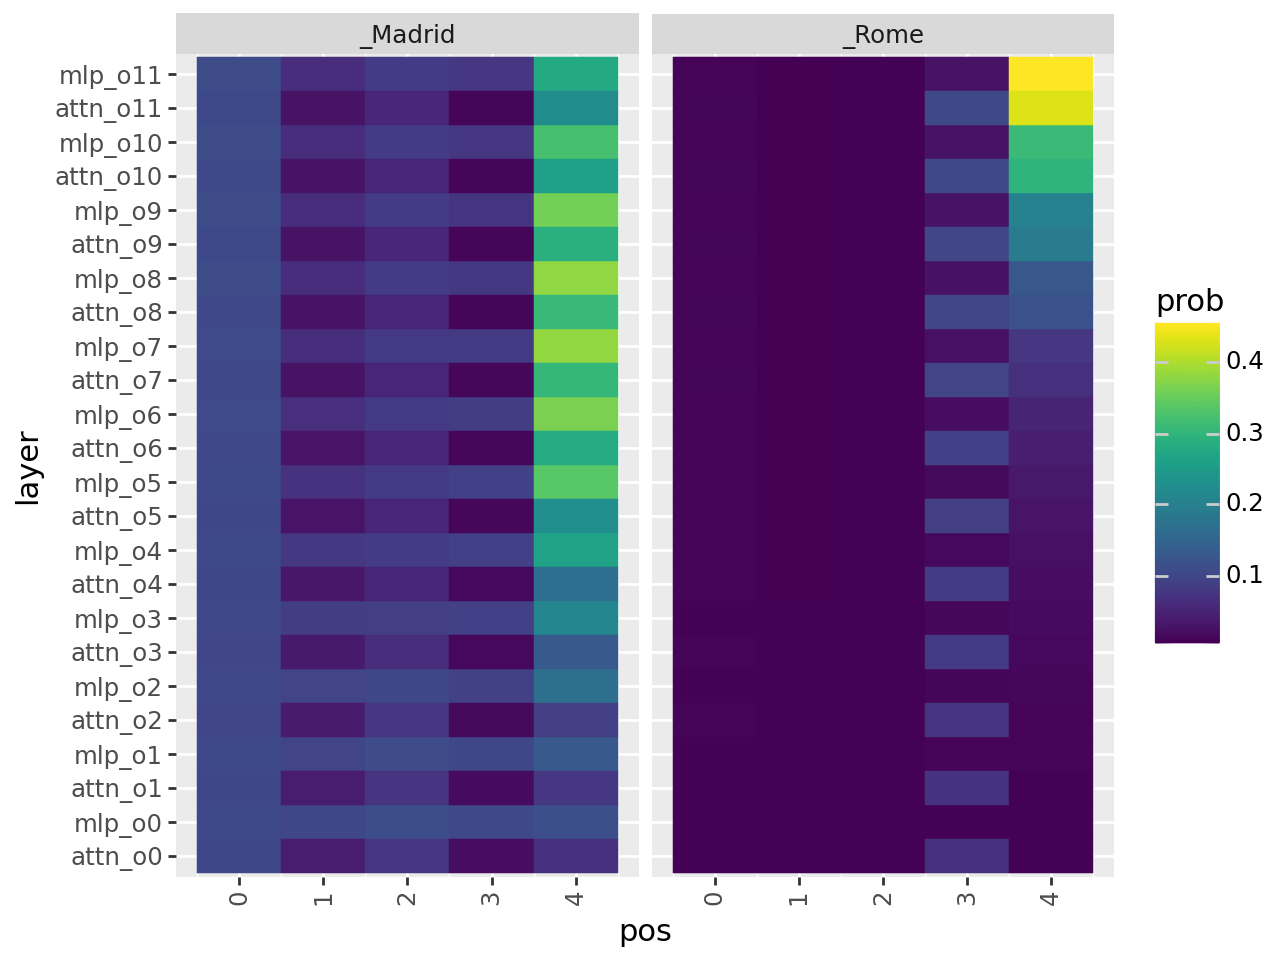

In [31]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"mlp_o{l}")
    nodes.append(f"attn_o{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)